In [610]:
from tqdm.notebook import tqdm as tqm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from scipy import fft
import seaborn as sns
from math import pi
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import soundfile
import time
from peakutils import indexes

import wave 
# Opciones de matplotlib
rc=plt.rcParams
rc['figure.figsize']=[15,5]

# Para mostrar todas las columnas cuando se imprime un df
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

Definimos las cantidades correspondientes a las características del problema

In [611]:
n_ventana=1024
freq_sampleo=48_000
N_mics=3


def arreglo_frecuencias(freq_sampleo,n_ventana):
    '''Función para obtener el arreglo de frecuencias que se obtendrían en la transformada de Fourier rápida'''
    f_NS=freq_sampleo//2
    freq_array=np.zeros(n_ventana)
    f1=freq_sampleo/n_ventana
    for i in range(1,len(freq_array)//2):
        freq_array[i]=f1*i 
        freq_array[len(freq_array)-i]=-freq_array[i]
    freq_array[n_ventana//2]=f_NS
    return freq_array

def freqs_idxs(freq_array,freq_low,freq_high,n=0):
    idx_low=max((freq_array<freq_low).argmin()-1,0)
    idx_high=min((freq_array>freq_high).argmax()+1,len(freq_array)-1)
    if idx_high==1:
        idx_high=len(freq_array)-1
    if n==0:
        n=idx_high-idx_low
    return np.unique(np.linspace(idx_low,idx_high,n).astype(int))




In [612]:
def filtro(x_mics:np.array,lim_bajo:float=0,lim_alto:float=np.inf,sampling_rate:int=48_000,keep_zero=False):

    if lim_bajo==0:
        idx_bajo=0
    else:
        idx_bajo=int(lim_bajo*x_mics.shape[1]/sampling_rate)
    
    if lim_alto==np.inf:
        idx_alto=x_mics.shape[1]
    else:
        idx_alto=int(lim_alto*x_mics.shape[1]/sampling_rate)
    
    freqs_bajo=list(range(0,idx_bajo))+list(range(x_mics.shape[1]-idx_bajo,x_mics.shape[1]))
    freqs_alto=list(range(idx_alto+1,x_mics.shape[1]))
    X=fft.fft(x_mics,axis=1)
    
    DC=X[:,0].copy()
    X[:,freqs_alto]=0
    X[:,freqs_bajo]=0

    if keep_zero:
        X[:,0]=DC
        
    return X




# Leyendo archivo de AIRA

Usando `wave` leemos el archivo de AIRA para comenzar las pruebas de music

In [613]:
def caracteristicas_onda(path):
    wave_object=wave.open(path,'rb')
    fr_AIRA=wave_object.getframerate() # 48000 Hz
    ns_AIRA=wave_object.getnframes() # 1539072 frames en total 
    T_AIRA=ns_AIRA/fr_AIRA # 32s 
    nchannels_AIRA=wave_object.getnchannels() # 1
    print(f'Caracteristicas de {path}')
    print('-'*70)
    print(f'{"Número total de frames:":25s} {ns_AIRA}')
    print(f'{f"Frame rate:":25s} {fr_AIRA} Hz')
    print(f'{"Duración total:":25s} {T_AIRA:4.2f} s')
    print(f'{"Número de canales de:":25s} {nchannels_AIRA}')

    return wave_object,fr_AIRA,ns_AIRA,T_AIRA,nchannels_AIRA

# Catacyerísticas de la onda
mic_path=['../Programas PDA/6. AIRA/clean-2source/wav_mic1.wav','../Programas PDA/6. AIRA/clean-2source/wav_mic2.wav','../Programas PDA/6. AIRA/clean-2source/wav_mic3.wav']
mic1,fr_AIRA,ns_AIRA,T_AIRA,nchannels_AIRA=caracteristicas_onda(mic_path[0])
mic2=caracteristicas_onda(mic_path[1])[0]
mic3=caracteristicas_onda(mic_path[2])[0]


Caracteristicas de ../Programas PDA/6. AIRA/clean-2source/wav_mic1.wav
----------------------------------------------------------------------
Número total de frames:   1539072
Frame rate:               48000 Hz
Duración total:           32.06 s
Número de canales de:     1
Caracteristicas de ../Programas PDA/6. AIRA/clean-2source/wav_mic2.wav
----------------------------------------------------------------------
Número total de frames:   1539072
Frame rate:               48000 Hz
Duración total:           32.06 s
Número de canales de:     1
Caracteristicas de ../Programas PDA/6. AIRA/clean-2source/wav_mic3.wav
----------------------------------------------------------------------
Número total de frames:   1539072
Frame rate:               48000 Hz
Duración total:           32.06 s
Número de canales de:     1


Definimos función para leer archivos y leer su contenido en numpy

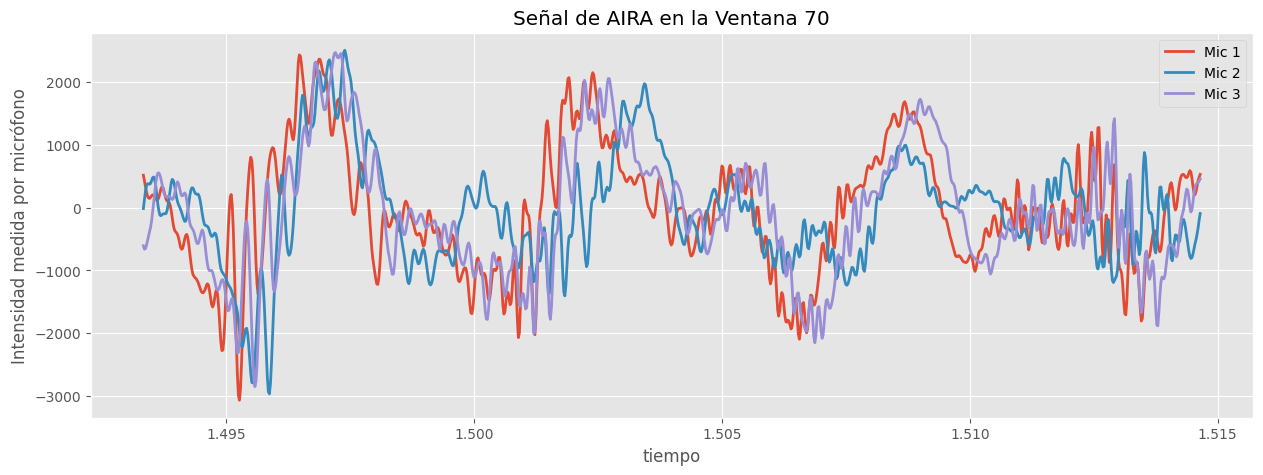

In [614]:
def leer_señal_array(path):
    wav_object=wave.open(f'{path}','rb')
    ns=wav_object.getnframes() # 1539072


    signal_wave=wav_object.readframes(ns)
    signal_array=np.frombuffer(signal_wave,dtype=np.int16)
    
    return signal_array


ventana_estudio=70 # Abajo de esta ventana empieza a agarrar ruido real

lista_señales_AIRA=[leer_señal_array(mic_path[0])[(1024*ventana_estudio):1024*(ventana_estudio+1)],leer_señal_array(mic_path[1])[(1024*ventana_estudio):1024*(ventana_estudio+1)],leer_señal_array(mic_path[2])[(1024*ventana_estudio):1024*(ventana_estudio+1)]]

n_ventanas_AIRA=lista_señales_AIRA[0].shape[0]//n_ventana 

time_AIRA=np.linspace(0,T_AIRA,num=ns_AIRA)[(1024*ventana_estudio):1024*(ventana_estudio+1)]


plt.title(f'Señal de AIRA en la Ventana {ventana_estudio}')
for i,li in enumerate(lista_señales_AIRA):
    plt.plot(time_AIRA,li,label=f'Mic {i+1}',linewidth=2)
plt.xlabel('tiempo'); plt.ylabel('Intensidad medida por micrófono')
plt.legend();plt.show();

## Cambiando A para ajustarse al arreglo triangular

Sabemos que la configuración de micrófonos de AIRA no es lineal, entonces tenemos que cambiar nuestros cálculos de los direction vectors. El arreglo está dado por 

![arr_AIRA](./imgs/arr_AIRA.png)



Para los dos primeros micrófonos es lo mismo, para el tercero es donde hay que cambiarlo. 

Como el triángulo entre los micrófonos es equilátero y la dirección contrarreloj es negativa, tenemos $$\theta_{m3}=-\frac{\pi}{2}-\frac{\pi}{3}=-\frac{5}{6}\pi$$

Así, el direction vector queda como 

$$ 
\begin{align}
{\vec{a}(\theta)}_{AIRA}^{f}=\begin{pmatrix}
1\\
e^{-if\frac{2\pi d}{c}\sin(\theta) }\\
e^{-if\frac{2\pi d}{c}\cos(-\frac{5}{6}\pi-\theta)}
\end{pmatrix}

\end{align}
$$


In [615]:
dm_AIRA=0.18 # Separación de micrófonos en metros (todas las separaciones son iguales porque es arreglo triangular equilátero)
c=343 #m/s

DOAS_AIRA=[-30,90]
N_mic_AIRA=3

def a_theta_f_AIRA(θ,freq,dm_AIRA=dm_AIRA,c=c):
    '''
    θ: Dirección de arribo con respecto a la referencia
    f: frecuencia de la señal
    dim: distancia entre micrófonos, para el arreglo de AIRA es el mismo porque es triángulo equilatero
    Genera los steering vector en la dirección θ para el arreglo triangular de AIRA
    '''
    θ_rad=θ*pi/180
    k=-2*pi*dm_AIRA/c*np.sin(θ_rad)
    a=[
        1+0j, # Micrófono 1
        np.exp(k*freq*1j), # Micrófono 2
        np.exp(-2*pi*freq*dm_AIRA/c*np.cos(-5*pi/6-θ_rad)*1j) # Micrófono 3
       ]
    return np.array(a)

def A_f_AIRA(θs,freq,dm_AIRA=dm_AIRA,c=c):
    '''
    Función que genera la matriz de steering vectors para una frecuencia específica con varias fuentes ubicadas en θs
    '''
    A=np.zeros(shape=(N_mic_AIRA,len(θs)))+0j
    for i in range(len(θs)):
        A[:,i]=a_theta_f_AIRA(θs[i],freq,dm_AIRA=dm_AIRA,c=c)
    
    return A


def A_AIRA(θs,freqs,dm_AIRA=dm_AIRA,c=c):
    '''
    Para arreglo lineal. 
    Calcula el tensor A para las frecuencias requeridas apliando matrices de steering vectors
    '''
    A=np.zeros(shape=(len(freqs),N_mic_AIRA,len(θs)))+0j
    for i in range(len(freqs)):
        A[i,:,:]=A_f_AIRA(θs,freqs[i],dm_AIRA=dm_AIRA,c=c)
    
    return A



# Aproximando señales con transformación de $A$

Vemos las señales originales las transformamos con la A y esperamos ver algo parecido a la de los micrófonos 

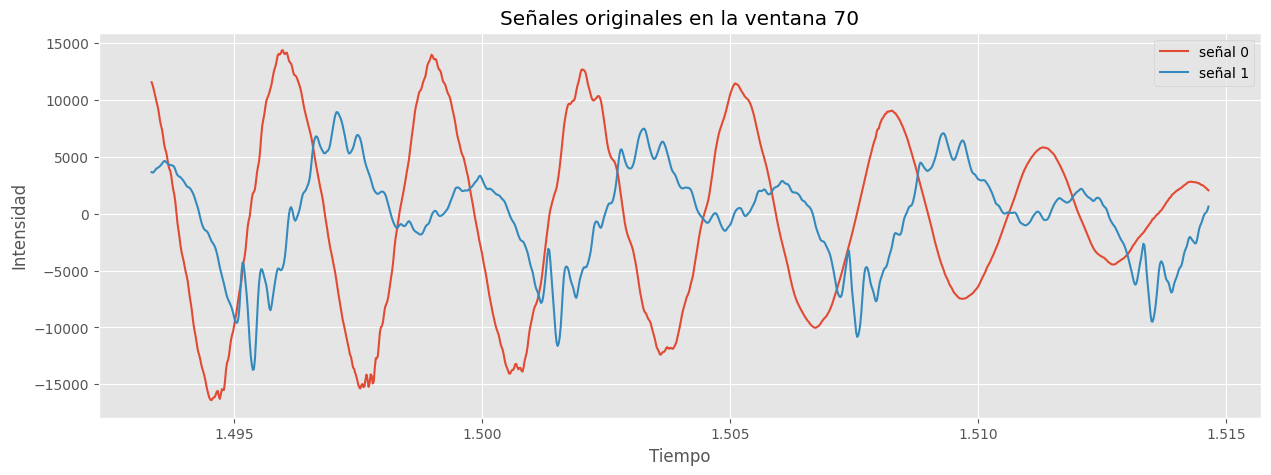

In [616]:
s1_AIRA=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/pristine_channel1.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]
s2_AIRA=leer_señal_array('../Programas PDA/6. AIRA/clean-2source/pristine_channel2.wav')[(1024*ventana_estudio):1024*(ventana_estudio+1)]

freq_array_AIRA=arreglo_frecuencias(freq_sampleo=fr_AIRA,n_ventana=1024)
s_vec_AIRA=np.c_[s1_AIRA,s2_AIRA]

plt.title(f'Señales originales en la ventana {ventana_estudio}')
for i,si in enumerate(s_vec_AIRA.T):
    plt.plot(time_AIRA,si,label=f'señal {i}')
plt.xlabel('Tiempo');plt.ylabel('Intensidad');plt.legend();plt.show()

In [617]:
A_AIRA_mat=A_AIRA(DOAS_AIRA,freq_array_AIRA)
s_hat_vec_AIRA=fft.fft(s_vec_AIRA,axis=0)
x_mics_AIRA_señal=np.zeros((N_mic_AIRA,len(freq_array_AIRA)))+0j
for i in range(A_AIRA_mat.shape[0]):
    x_mics_AIRA_señal[:,i]=A_AIRA_mat[i,:,:]@s_hat_vec_AIRA[i,:]
x_mics_AIRA_señal=fft.ifft(x_mics_AIRA_señal,axis=1).real

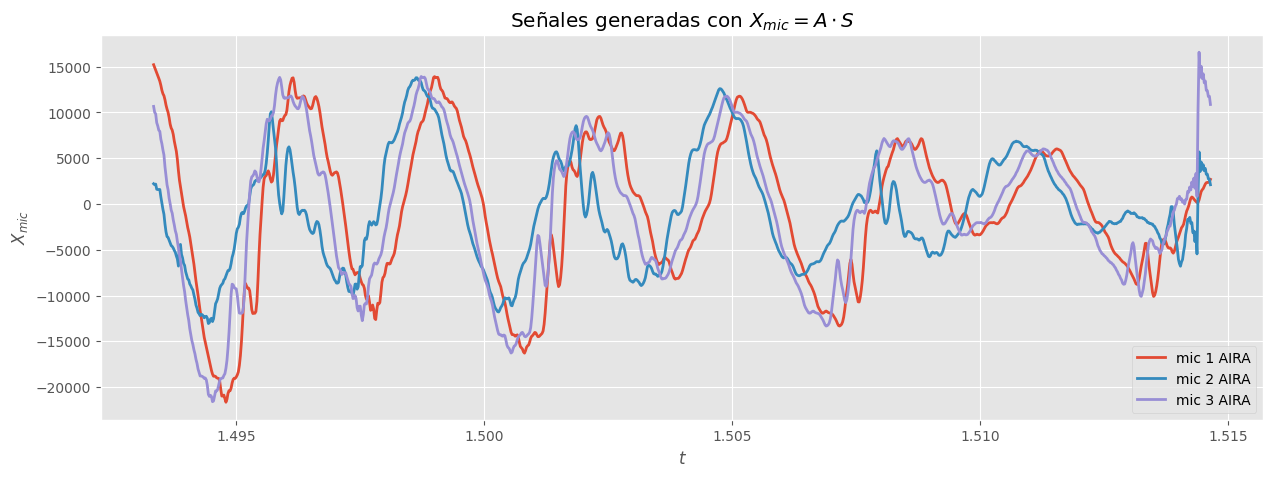

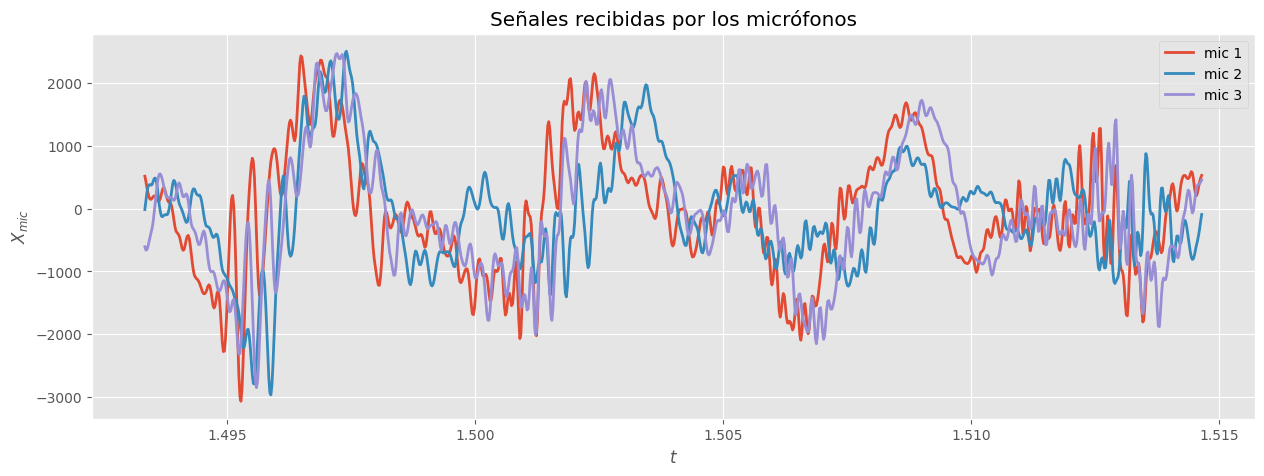

In [618]:

plt.plot(time_AIRA,x_mics_AIRA_señal[0],label='mic 1 AIRA',linewidth=2)
plt.plot(time_AIRA,x_mics_AIRA_señal[1],label='mic 2 AIRA',linewidth=2)
plt.plot(time_AIRA,x_mics_AIRA_señal[2],label='mic 3 AIRA',linewidth=2)
plt.title('Señales generadas con $X_{mic}=A\\cdot S$');plt.legend(); plt.xlabel('$t$');plt.ylabel('$X_{mic}$');plt.show()

plt.plot(time_AIRA,lista_señales_AIRA[0],label='mic 1',linewidth=2)
plt.plot(time_AIRA,lista_señales_AIRA[1],label='mic 2',linewidth=2)
plt.plot(time_AIRA,lista_señales_AIRA[2],label='mic 3',linewidth=2)
plt.title('Señales recibidas por los micrófonos');plt.legend(); plt.xlabel('$t$');plt.ylabel('$X_{mic}$');plt.show()

la diferencia con las señales de los micrófonos se debe a el ruido, reverb y la distancia? Cómo se podría emular esto para crear señales sintéticas y poder hacer experimentos con diferentes señales?

También se podría cambiar la frecuencia de una señal y ver si esto ayuda a mejorar el proceso de  DOA. Poner una de ellas muy aguda y la otra muy grave. 

# MUSIC con señal real

Redefinimos la función de MUSIC para que agarre el arreglo triangular de AIRA

In [619]:
def MUSIC_AIRA(freq_array,this_idx,x_mics,angles,n_ruidoso,filter=[]):
    '''
    Función para encontrar el espectro de music. Depende del arreglo de micrófonos a través de A_completa
    x_mics: el arreglo de señales que ve cada micrófono
    '''
    
    # Se pone con media cero
    x_mics =x_mics-x_mics.mean(axis=1).reshape(-1,1)

    # Se tiene que tener cuidado que las frecuencias estén por abajo de las filtradas
    if len(filter)>0:
        X=filtro(x_mics,lim_bajo=filter[0],lim_alto=filter[1],sampling_rate=48_000)

    else:
        X=fft.fft(x_mics,axis=1) # se hace la transformada a lo largo del eje 1 para obtener una transformada por cada mic

    this_ws=freq_array[this_idx] # Frecuencias donde se van a buscar los picos del espectro de MUSIC
    music_spectrum=np.zeros(shape=(len(this_ws),len(angles)))
    for i,idx in enumerate(this_idx):
        this_X=X[:,idx] # Se calcula en una frecuencia particular la señal de fourier para hacer correlación con ella. 
        R=this_X.reshape(-1,1)*this_X.conj().T
        D,Q=np.linalg.eig(R)
        I=np.argsort(D.real)[::-1]
        D=D[I]
        Q=Q[:,I]


        # Qs=Q[:,1:n_ruidoso]
        Qn=Q[:,n_ruidoso:]

        wi=this_ws[i]
        A_angles=A_AIRA(θs=angles,freqs=[wi])

        for k in range(len(angles)):
            music_spectrum[i,k]=np.abs(1/(A_angles[0,:,k].conj().T@(Qn*Qn.conj().T@A_angles[0,:,k])))
    return music_spectrum


Como esto tiene que correr en tiempo real, se debe realizar en menos de $$t_{\text{ventana}}=\frac{\text{frames por ventana}}{\text{frame rate}}=\frac{1024}{48000 \text{ Hz}}\approx 0.021 \text{s}$$

Frecuencia fundamental típica de un hombre va de 80 a 150Hz mientras que la de una mujer va de 166 a 255Hz ([Fuente Wikipedia](https://en.wikipedia.org/wiki/Voice_frequency)).

Entonces vamos a buscar en espacio de frecuencias para music que incluya estas frecuencias aunque también deberíamos incluir más porque 

In [620]:
periodo_AIRA=n_ventana/fr_AIRA
this_idx_AIRA=freqs_idxs(freq_array_AIRA,freq_low=100,freq_high=500,n=5)[:-1]


x_mics_AIRA=np.array(lista_señales_AIRA)-np.array(lista_señales_AIRA).mean(axis=1).reshape(-1,1)
n_ruidoso_AIRA=2
# frecuencias fundamentales de la voz humana de hombre van de 80 a 180 Hz

angles_AIRA=np.linspace(-180,180,50) # Los ángulos de los direction vectors para buscar ortogonalidad

music_spectrum_AIRA=MUSIC_AIRA(freq_array=freq_array_AIRA,this_idx=this_idx_AIRA,x_mics= x_mics_AIRA,angles=angles_AIRA,n_ruidoso=n_ruidoso_AIRA,filter=[100,500])

music_spectrum_AIRA.shape # (número de frecuencias, número de ángulos de búsqueda)

(4, 50)

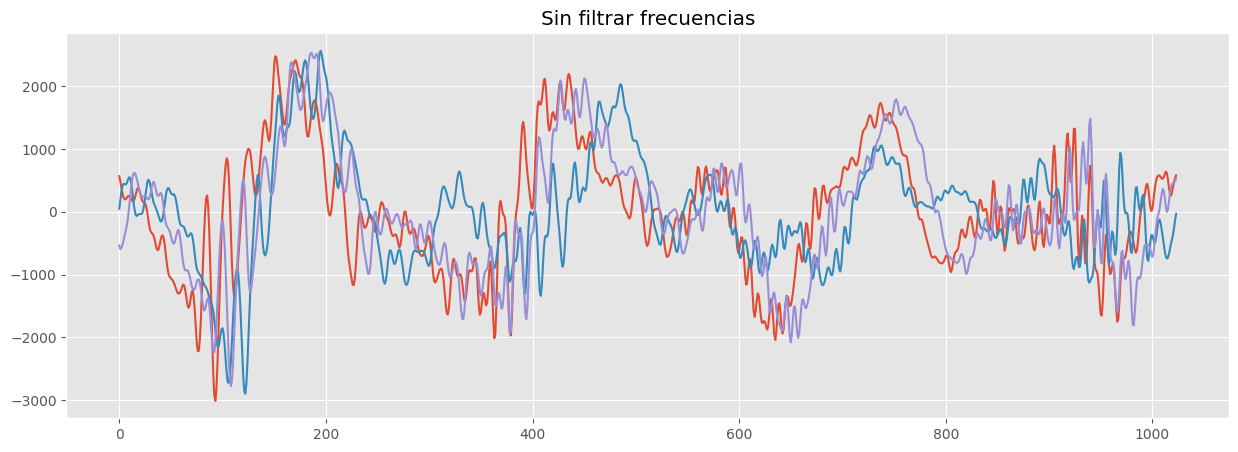

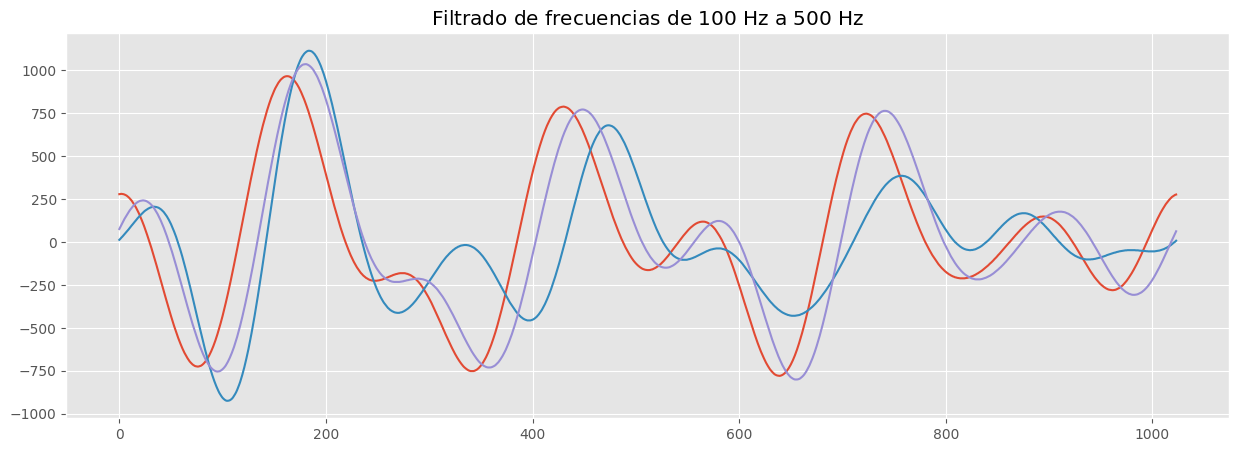

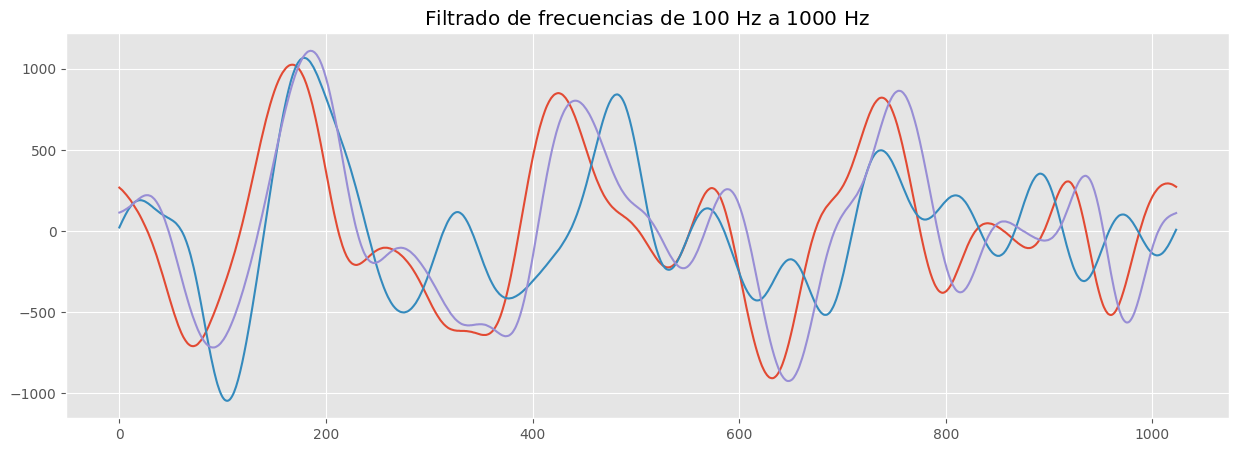

In [621]:
# Gráfica de filtrado de frecuencias

plt.plot(x_mics_AIRA[0])
plt.plot(x_mics_AIRA[1])
plt.plot(x_mics_AIRA[2])
plt.title('Sin filtrar frecuencias');plt.show()

filtro_xma=[100,500]
plt.plot(fft.ifft(filtro(x_mics_AIRA,filtro_xma[0],filtro_xma[1],keep_zero=True)).real.astype(int)[0])
plt.plot(fft.ifft(filtro(x_mics_AIRA,filtro_xma[0],filtro_xma[1],keep_zero=True)).real.astype(int)[1])
plt.plot(fft.ifft(filtro(x_mics_AIRA,filtro_xma[0],filtro_xma[1],keep_zero=True)).real.astype(int)[2])
plt.title(f'Filtrado de frecuencias de ${filtro_xma[0]}$ Hz a ${filtro_xma[1]}$ Hz ');plt.show()

filtro_xma=[100,500]
plt.plot(fft.ifft(filtro(x_mics_AIRA,100,1000)).real.astype(int)[0])
plt.plot(fft.ifft(filtro(x_mics_AIRA,100,1000)).real.astype(int)[1])
plt.plot(fft.ifft(filtro(x_mics_AIRA,100,1000)).real.astype(int)[2])
plt.title(f'Filtrado de frecuencias de ${filtro_xma[0]}$ Hz a ${1000}$ Hz ');plt.show()

In [622]:
def agrupacion_maximos(music_spectrum,angles):
    '''Función que regresa los dos (por el número de fuentes) máximos de cada uno de los espectros de MUSIC, primero regresa el segundo menor y luego el primero, también regresa las intensidades por si se quisiera hacer algo con eso'''
    idxs_maxs=np.argpartition(music_spectrum_AIRA,-2,axis=1)[:,-2:]
    return angles[idxs_maxs], music_spectrum[:,idxs_maxs.reshape(-1)]

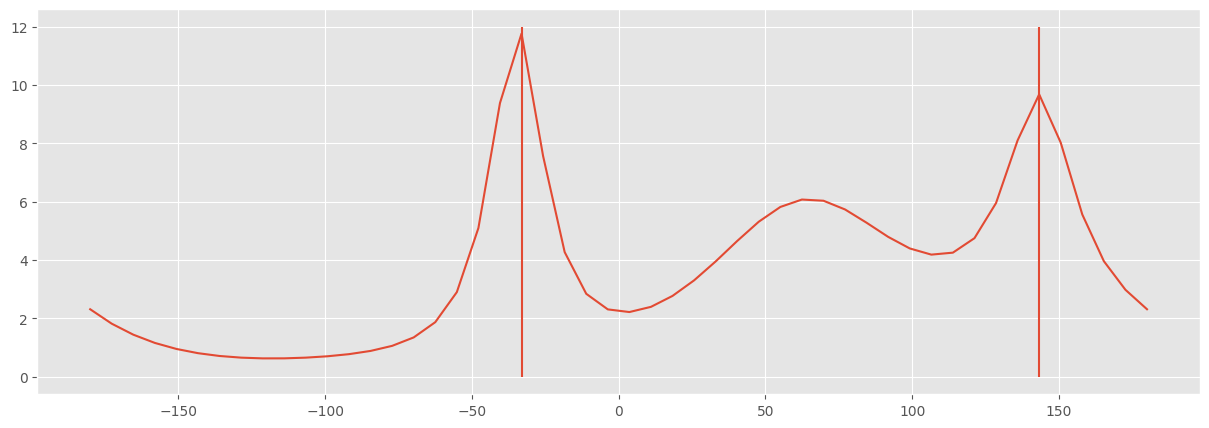

In [623]:
def agrupacion_promedio(music_spectrum,angles):
    avg=np.mean(music_spectrum,axis=0)
    idxs_max=np.argpartition(avg,-2)[-2:]
    return angles[idxs_max],avg[idxs_max]

plt.plot(angles_AIRA, music_spectrum_AIRA.mean(axis=0)-1)
plt.vlines(x=agrupacion_promedio(music_spectrum_AIRA-1,angles_AIRA)[0],ymin=0,ymax=12)

hay un problema con que puede agarrar ángulos muy cortos porque hay picos mucho mayores, entonces se deberían de alcanzar dos máximos locales probablemente

In [624]:
def encontrar_peaks(music_spectrum,angles,umbral_prop=0.3,idx_dist=5):

    idxs_peaks=indexes(y=music_spectrum,thres=umbral_prop, min_dist=idx_dist)
    
    return angles[idxs_peaks]



In [625]:
%%timeit
encontrar_peaks(music_spectrum=music_spectrum_AIRA[1],angles=angles_AIRA)

59.5 µs ± 7.92 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


tarda mucho tiempo

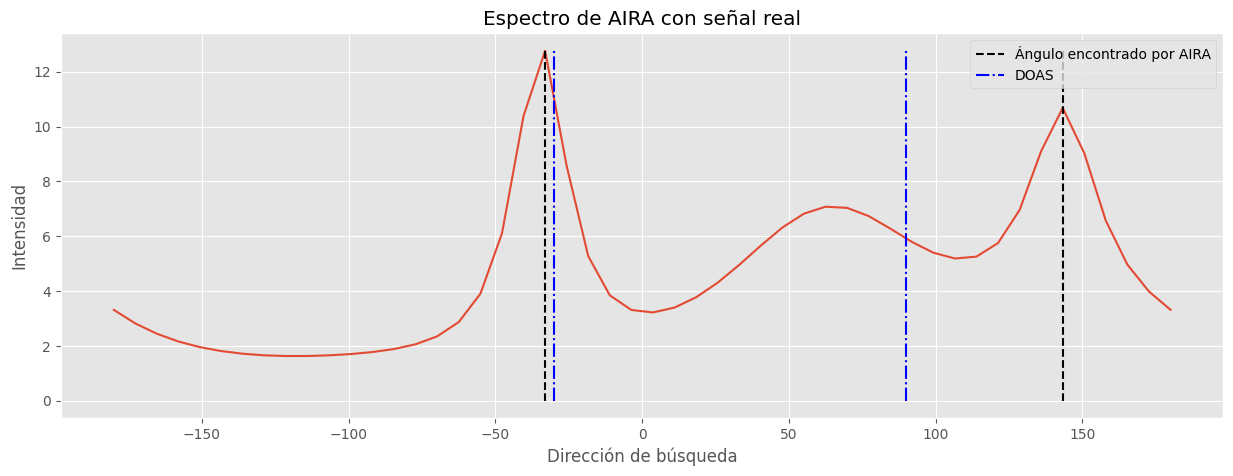

In [628]:
def tomar_max_locales(music_spectrum,angles,umbral,umbral_der=180,umbral_altura=0):
    avg=music_spectrum.mean(axis=0)
    idx_sort=np.argsort(avg)[::-1]
    angs_maximos=np.array([angles[idx_sort[0]],angles[idx_sort[0]]])

    for idx_ang in idx_sort:
        ang=angles[idx_ang]
        if abs(ang-angs_maximos[0])>umbral and abs(ang-angs_maximos[0])<umbral_der and avg[idx_ang]/avg.max()>=umbral_altura:
            angs_maximos[1]=ang 
            return angs_maximos, avg[[idx_sort[0],idx_ang]]
    return np.array(angles[idx_sort[0]])

angles_AIRA=np.linspace(-180,180,50)
music_spectrum_AIRA=MUSIC_AIRA(freq_array=freq_array_AIRA,this_idx=this_idx_AIRA,x_mics= x_mics_AIRA,angles=angles_AIRA,n_ruidoso=n_ruidoso_AIRA,filter=[100,500])
tomar_max_locales(music_spectrum_AIRA,angles_AIRA,10)

plt.plot(angles_AIRA, music_spectrum_AIRA.mean(axis=0))
plt.vlines(x=tomar_max_locales(music_spectrum_AIRA,angles_AIRA,umbral=30)[0],ymin=0,ymax=music_spectrum_AIRA.mean(axis=0).max(),colors='k',linestyles='dashed',label='Ángulo encontrado por AIRA')
plt.vlines(x=DOAS_AIRA,ymin=0,ymax=music_spectrum_AIRA.mean(axis=0).max(),colors='b',linestyles='dashdot',label='DOAS');plt.legend();plt.title('Espectro de AIRA con señal real'); plt.xlabel('Dirección de búsqueda');plt.ylabel('Intensidad'); plt.show()

In [604]:
%%timeit

music_spectrum_AIRA=MUSIC_AIRA(freq_array=freq_array_AIRA,this_idx=this_idx_AIRA,x_mics= x_mics_AIRA,angles=angles_AIRA,n_ruidoso=n_ruidoso_AIRA,filter=[100,500])
tomar_max_locales(music_spectrum_AIRA,angles_AIRA,30)

3.58 ms ± 620 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Como tarda $\approx 5.54 \text{ ms}<20 -text{ ms}$ en acabar, se puede hacer el cálculo del espectro de music y aún así seguir debajo del límite para cálculo en línea. Todavía tenemos que calcular los máximos y ver que el tiempo se queda dentro de lo establecido

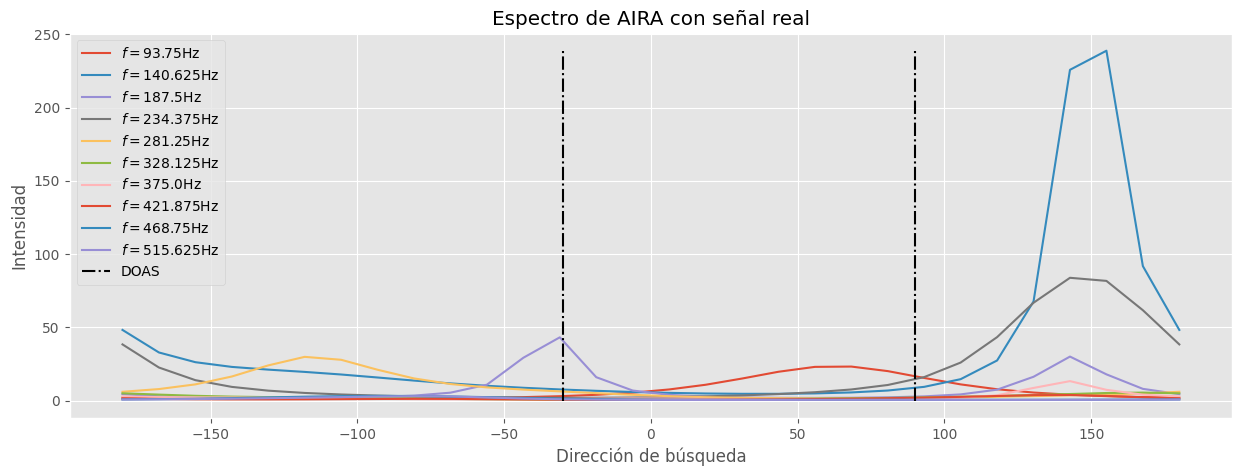

In [606]:
this_idx_AIRA=freqs_idxs(freq_array_AIRA,freq_low=100,freq_high=500,n=30)[:-1]
angles=np.linspace(-180,180,30)
music_spectrum_AIRA=MUSIC_AIRA(freq_array_AIRA,this_idx=this_idx_AIRA,x_mics=x_mics_AIRA,angles=angles,n_ruidoso=2,filter=[70,1000])

for i in range(music_spectrum_AIRA.shape[0]):
    plt.plot(angles,music_spectrum_AIRA[i,:],label=f'$f={freq_array_AIRA[this_idx_AIRA][i]} $Hz')

plt.vlines(x=DOAS_AIRA,ymin=0,ymax=music_spectrum_AIRA.max(),colors='k',linestyles='dashdot',label='DOAS');plt.legend();plt.title('Espectro de AIRA con señal real'); plt.xlabel('Dirección de búsqueda');plt.ylabel('Intensidad'); plt.show()

## Leyendo el archivo completo

Vamos leyendo el archivo ventana por ventana almacenando los ángulos que se predicen como los máximos.

Los 3 micrófonos empiezan a grabar al mismo tiempo así que no hay problema con las cosas

In [341]:
ventanas=100

this_idx_AIRA=freqs_idxs(freq_array_AIRA,freq_low=100,freq_high=500,n=5)[:-1]
this_ws_AIRA=freq_array_AIRA[this_idx_AIRA]
angles_AIRA=np.linspace(-180,180,50) # Los ángulos de los direction vectore para buscar ortogonalidad
angulos_maximos_lista=[]
intensidades_maximas_lista=[]

lista_señales_AIRA=[leer_señal_array(mic_path[0]),leer_señal_array(mic_path[1]),leer_señal_array(mic_path[2])]

for ventana in range(ventanas):
    x_mics_AIRA=np.array([lsa[(1024*(ventana_estudio+ventana)):1024*(ventana_estudio+ventana+1)] for lsa in lista_señales_AIRA])
    music_spectrum_AIRA=MUSIC_AIRA(freq_array=freq_array_AIRA,this_idx=this_idx_AIRA,x_mics= x_mics_AIRA,angles=angles_AIRA,n_ruidoso=n_ruidoso_AIRA,filter=filtro_xma)
    angulos_maximos_lista.append(tomar_max_locales(music_spectrum_AIRA,angles_AIRA,30)[0])
    intensidades_maximas_lista.append(tomar_max_locales(music_spectrum_AIRA,angles_AIRA,30)[1])
    


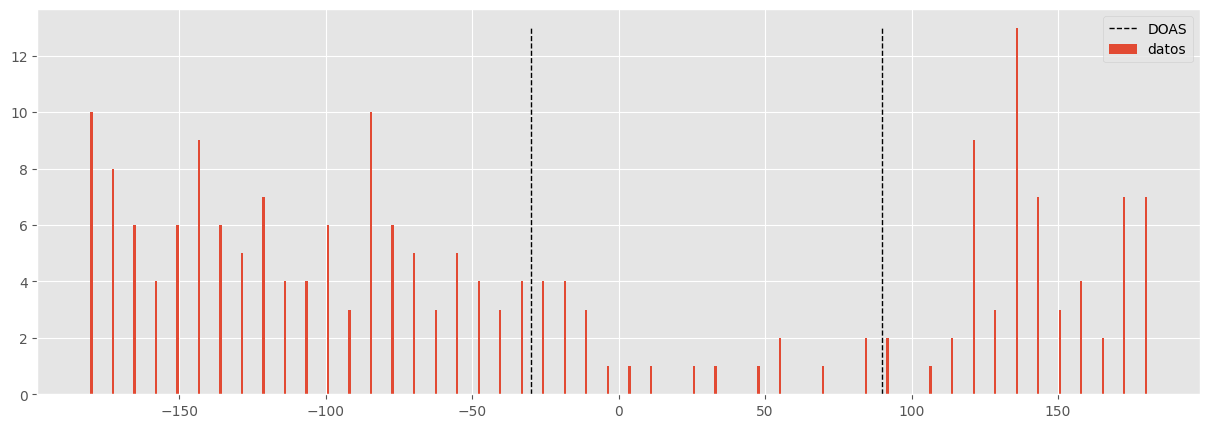

In [343]:
bar_data=pd.value_counts(np.array(angulos_maximos_lista).reshape(-1))

plt.bar(bar_data.index,bar_data,label='datos')
plt.vlines(DOAS_AIRA,ymin=0,ymax=bar_data.max(),colors='k',linestyles='dashed',linewidth=1,label='DOAS')
plt.legend();plt.show()

Sumando las intensidades en un ángulo dado

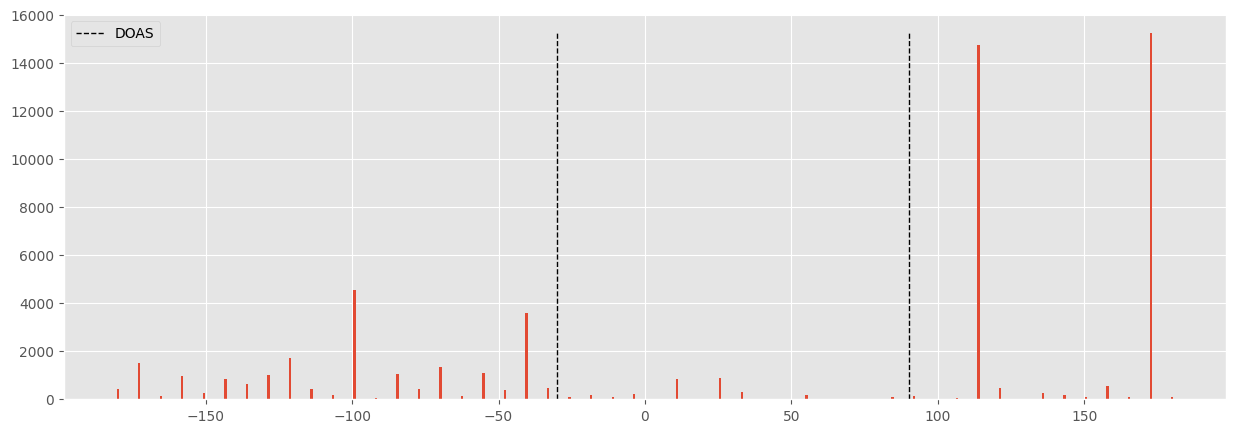

In [344]:
intensidades_maximas_arr=np.array(intensidades_maximas_lista).reshape(-1)
angulos_maximos_arr=np.array(angulos_maximos_lista).reshape(-1)
suma_maxs=[]

for angulo in np.unique(angulos_maximos_arr):
    suma_maxs.append(intensidades_maximas_arr[angulos_maximos_arr==angulo].sum())

plt.bar(np.unique(angulos_maximos_arr),suma_maxs)
plt.vlines(DOAS_AIRA,ymin=0,ymax=max(suma_maxs),colors='k',linestyles='dashed',linewidth=1,label='DOAS')
plt.legend();plt.show()

Para irle cambiando a los parámetros hay que ponerlo todo en una función

In [348]:
class DOAS_estimation:
    def __init__(self,mics_path:list[str],dm:float=0.18,DOAS:list=[-30,90],N_mics:int=3,n_ventana:int=1024,freq_sampleo:int=48_000,angulos:np.array=np.linspace(-90,90,50),n_ruidoso:int=2,filtro:list=[0,np.inf]):

        self.mics_path=mics_path
        self.dm=dm
        self.DOAS=DOAS 
        self.N_mics=N_mics 
        self.n_ventana=n_ventana
        self.freq_sampleo=freq_sampleo
        self.freq_array=arreglo_frecuencias(freq_sampleo,n_ventana)

        self.filtro=filtro
        self.nframes=[]
        self.angulos=angulos
        self.n_ruidoso=n_ruidoso
        self.angulos_maximos=[]
        self.intensidad_maxima=[]
        self.x_mics=[]

        for idx,mpath in enumerate(mics_path):
            nframe,x_mic=self.leer_señal_array(mpath)
            self.nframes.append(nframe)
            self.x_mics.append(x_mic)
        
        self.nframes=np.array(self.nframes)
        self.x_mics=np.array(self.x_mics)

    def leer_señal_array(self,path):
        wav_object=wave.open(f'{path}','rb')
        nframes=wav_object.getnframes() # 1539072


        signal_wave=wav_object.readframes(nframes)
        x_mics=np.frombuffer(signal_wave,dtype=np.int16)
        return nframes,x_mics
    
    def calcular_angulos_intensidades(self,ventana_inicial,nventanas,freq_low,freq_high,nfreqs=0,funcion_max=tomar_max_locales,umbral=10):
        '''funcion_max es una funcion que regresa un conjunto de ángulos y sus respectivas intensidades de acuerdo al espectro de music'''

        idx_freq=freqs_idxs(self.freq_array,freq_low,freq_high,nfreqs)[:-1]
        self.umbral=umbral
        self.ventana_inicial=ventana_inicial
        self.nventanas=nventanas
        # print('Frecuencias de búsqueda',self.freq_array[idx_freq])
        for ventana in range(nventanas):
            x_mics=self.x_mics[:,self.n_ventana*(ventana_inicial+ventana):self.n_ventana*(ventana_inicial+ventana+1)]
            music_spectrum=MUSIC_AIRA(freq_array=self.freq_array,this_idx=idx_freq,x_mics=x_mics,angles=self.angulos,n_ruidoso=self.n_ruidoso,filter=[freq_low,freq_high])

            # Obtenemos los ángulos máximos de cada espectro mediante alguna función
            angs,intensidadades=funcion_max(music_spectrum,self.angulos,umbral)

      

            idx_sort=np.argsort(angs) # Para tener los ángulos e intensidades almacenadas
            self.angulos_maximos.append(angs[idx_sort])
            self.intensidad_maxima.append(intensidadades[idx_sort])
    
    def graficar_datos_angulos(self):
        bar_data=pd.value_counts(np.array(self.angulos_maximos).reshape(-1))
       

        plt.bar(bar_data.index,bar_data,label='datos')
        plt.vlines(self.DOAS,ymin=0,ymax=bar_data.max(),colors='k',linestyles='dashed',linewidth=1,label='DOAS')
        plt.title(f'Distribución de máximos de ángulos separados por {self.umbral}\nDesde la ventana {self.ventana_inicial} hasta la {self.ventana_inicial+self.nventanas}');plt.xlabel('Ángulo de búsqueda');plt.ylabel('Cuenta de máximos')
        plt.legend();plt.show()

    def graficar_datos_intensidades(self):
        intensidades_maximas_arr=np.array(self.intensidad_maxima).reshape(-1)
        angulos_maximos_arr=np.array(self.angulos_maximos).reshape(-1)
        suma_maxs=[]

        for angulo in np.unique(angulos_maximos_arr):
            suma_maxs.append(intensidades_maximas_arr[angulos_maximos_arr==angulo].sum())

        plt.bar(np.unique(angulos_maximos_arr),suma_maxs)
        plt.vlines(self.DOAS,ymin=0,ymax=max(suma_maxs),colors='k',linestyles='dashed',linewidth=1,label='DOAS')
        plt.legend();plt.show()
        
        return
    

Vemos los ángulos donde se presentan los máximos con mayor frecuencia

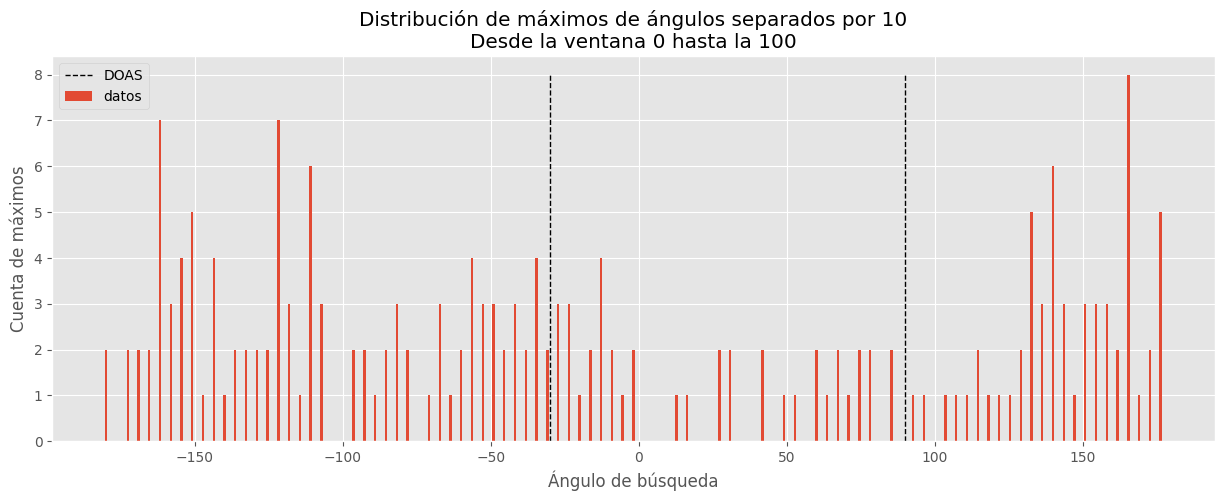

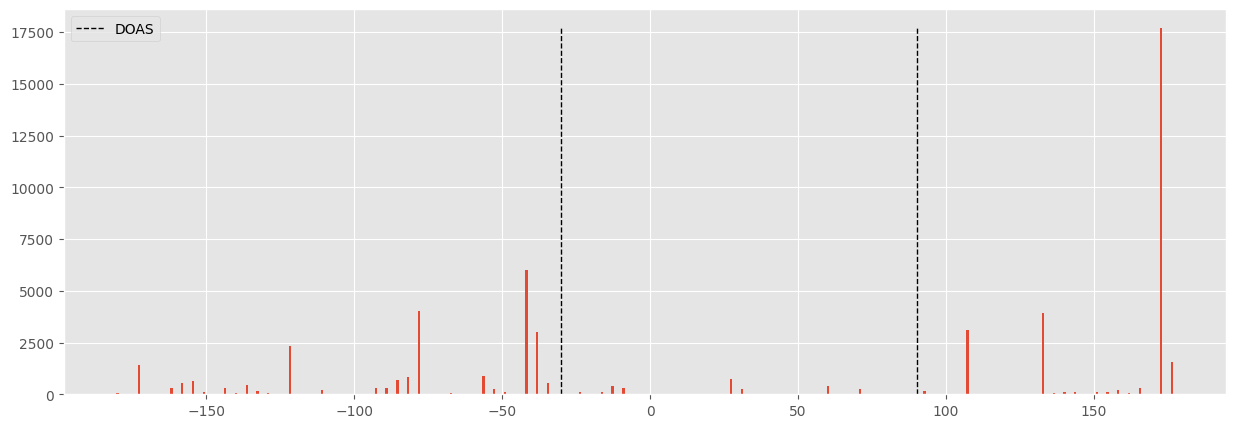

In [349]:
ms=DOAS_estimation(mic_path,angulos=np.linspace(-180,180,100))
ms.calcular_angulos_intensidades(ventana_inicial=0,nventanas=100,freq_low=100,freq_high=500,nfreqs=5,umbral=10)
ms.graficar_datos_angulos()
ms.graficar_datos_intensidades()

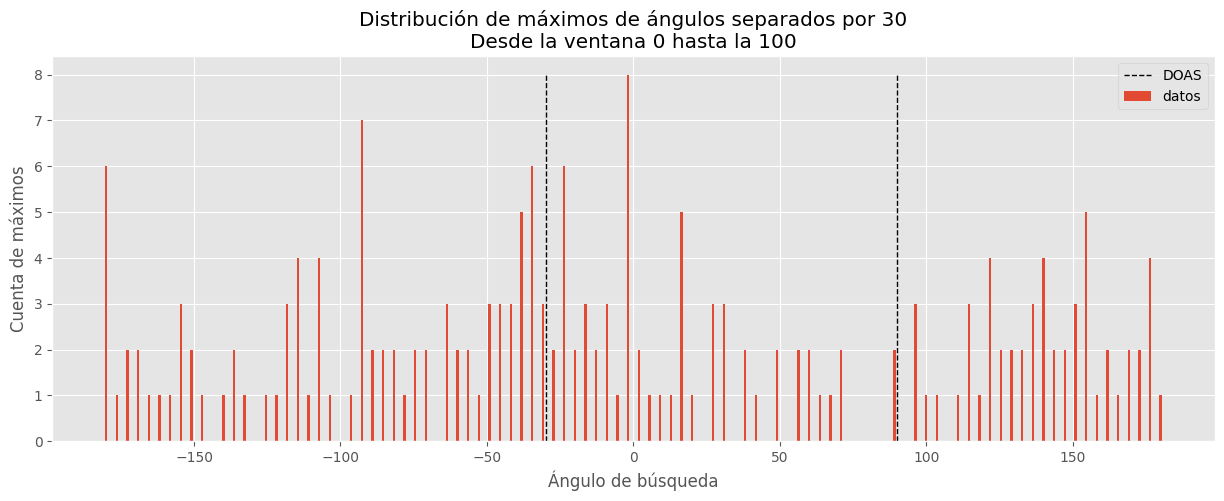

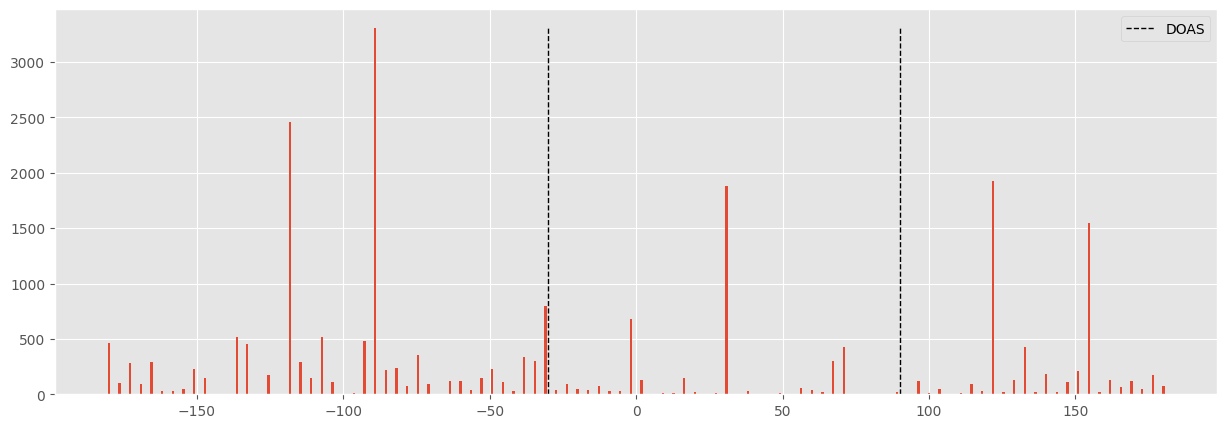

In [350]:
ms=DOAS_estimation(mic_path,angulos=np.linspace(-180,180,100))
ms.calcular_angulos_intensidades(ventana_inicial=0,nventanas=100,freq_low=500,freq_high=1000,umbral=30)
ms.graficar_datos_angulos()
ms.graficar_datos_intensidades()

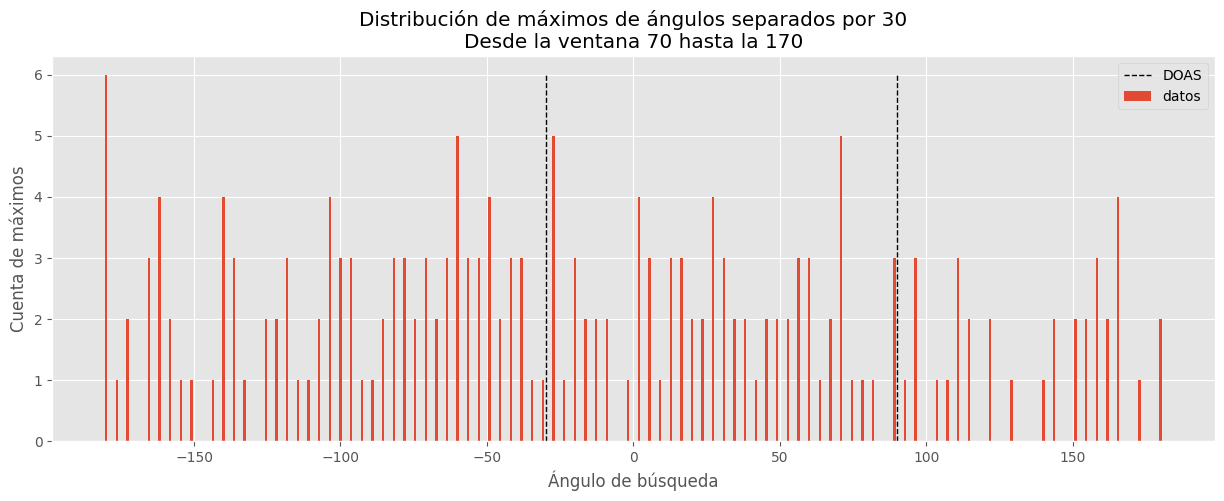

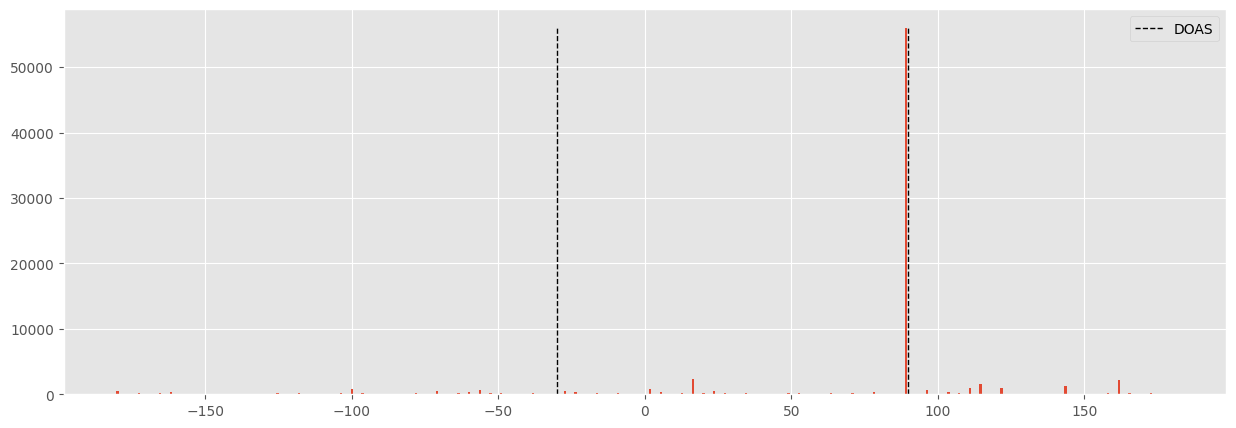

In [351]:
ms=DOAS_estimation(mic_path,angulos=np.linspace(-180,180,100))
ms.calcular_angulos_intensidades(ventana_inicial=ventana_estudio,nventanas=100,freq_low=0,freq_high=np.inf,umbral=30)
ms.graficar_datos_angulos()
ms.graficar_datos_intensidades()

Ya habiendo corrido con todas las frecuencias, se ve que los que tienen más máximos separados al menos 10 grados son el -75 y el 90 y cuando cambiamos el umbral a 30 grados de separación obtenemos las DOAS reales. Este enfoque no es práctico porque tenemos que usar todas las frecuencias y esto puede tardar más de lo esperado

Simulamos la captura en tiempo real de la señal de audio leyendo ventana por ventana las señales de los micrófonos y calculando los dos máximos

In [631]:
def bootstrap(x,alpha=0.05,B=100,func=np.mean):
    '''Devuelve la media remuestreando'''
    l=x.shape[0] #min(l,1000)
    T_estr=np.zeros(shape=(B,x.shape[1]))
    for i in range(B):
        idx=np.random.choice(np.arange(l),size=l)
        x_estr=x[idx,:]
        T_estr[i]=func(x_estr,axis=0)
    L,U=np.quantile(T_estr,q=[alpha/2,1-alpha/2],axis=0)
    return L,T_estr.mean(axis=0),U 

x=np.array(ms.angulos_maximos[:1000])


In [633]:
%%timeit
bootstrap(x,alpha=0.05,B=1000,func=np.mean)

49.8 ms ± 5.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [634]:
%%timeit
bootstrap(x,alpha=0.05,B=200,func=np.mean)

8.76 ms ± 601 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [642]:

ms=DOAS_estimation(mic_path,angulos=np.linspace(-180,180,50))

L,media,U=[],[],[]
tiempos=[]

for v in range(1000):
    # Este procedimiento simula el ir adquiriendo ventanas uno a uno es igual a calcularlo con ventana_inicial=0 y nventanas=1_000
    t1=time.time()
    ms.calcular_angulos_intensidades(ventana_inicial=v,nventanas=1,freq_low=100,freq_high=500,umbral=30)
    if len(ms.angulos_maximos)>30:
        x=np.array(ms.angulos_maximos)
        bstrp=bootstrap(x,alpha=0.05)
        L.append(bstrp[0])
        media.append(bstrp[1])
        U.append(bstrp[2])
    tiempos.append(time.time()-t1)
    
L=np.array(L)
media=np.array(media)
U=np.array(U)


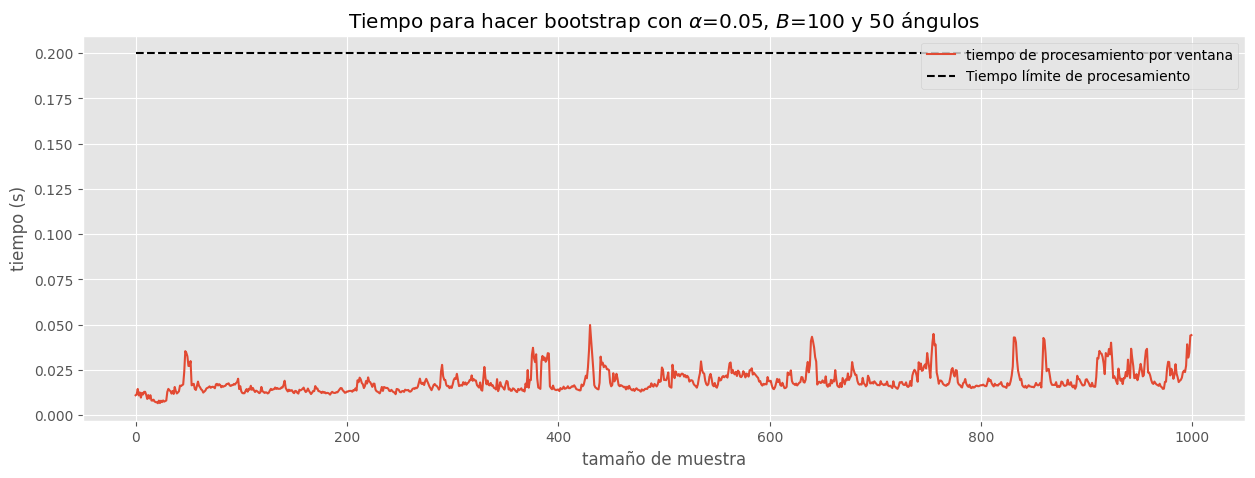

In [650]:
plt.plot(np.arange(len(tiempos)),np.array(tiempos),label='tiempo de procesamiento por ventana')
plt.hlines(0.20,xmin=0,xmax=len(tiempos),colors='k',linestyles='dashed',label='Tiempo límite de procesamiento')
plt.title(f'Tiempo para hacer bootstrap con $\\alpha$={0.05}, $B$=100 y 50 ángulos'); plt.xlabel('tamaño de muestra');plt.ylabel('tiempo (s)');plt.legend();plt.show();

## Usando kmeans

In [354]:
angs_maximos=np.array(ms.angulos_maximos).reshape(-1,1)
num_angulos=np.arange(10,len(ms.angulos_maximos))
lista_angs_km=[]

for i in num_angulos:
    km=KMeans(n_clusters=2,n_init='auto')

    km.fit(angs_maximos[:2*i])
    cc=km.cluster_centers_
    lista_angs_km.append(np.sort(cc.reshape(-1)))

In [355]:
arr_angs_km=np.array(lista_angs_km)
cum_mean=np.array(ms.angulos_maximos).cumsum(axis=0)/np.arange(1,np.array(ms.angulos_maximos).shape[0]+1).reshape(-1,1)

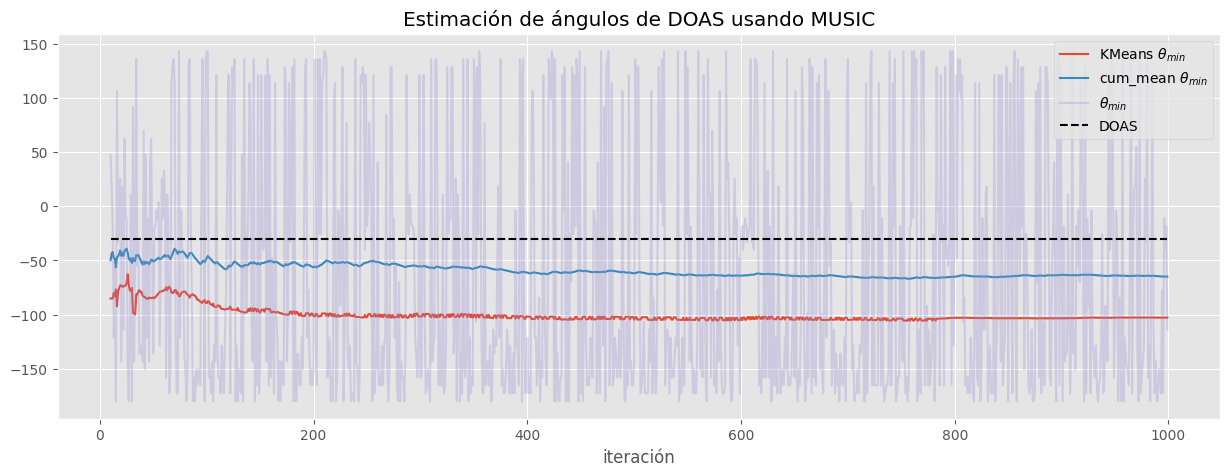

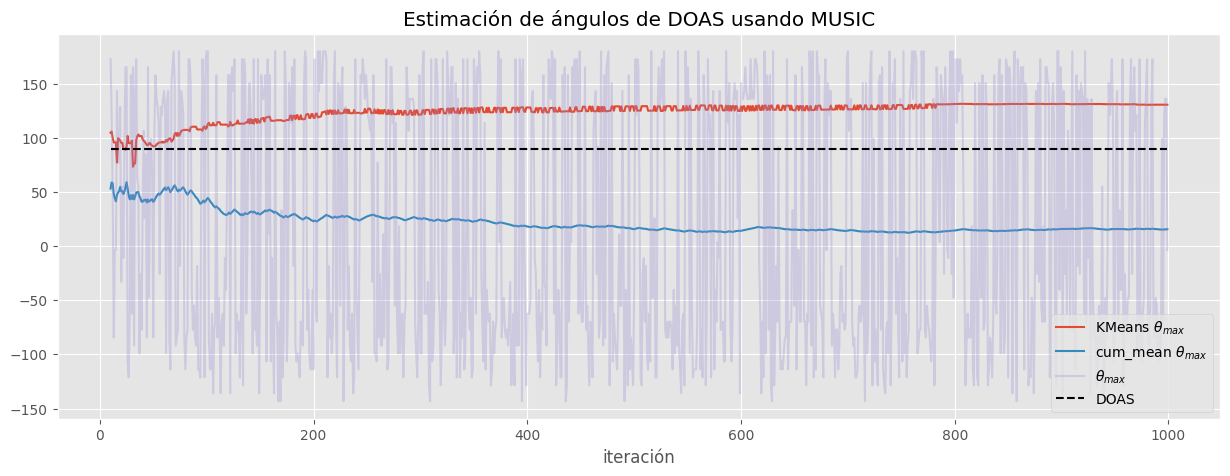

In [356]:
plt.plot(num_angulos,arr_angs_km[:,0],label='KMeans $\\theta_{min}$')
plt.plot(num_angulos,cum_mean[10:,0],label='cum_mean $\\theta_{min}$' )
plt.plot(num_angulos,np.array(ms.angulos_maximos)[10:,0],alpha=0.3, label='$\\theta_{min}$')
plt.hlines(y=DOAS_AIRA[0],xmin=num_angulos[0],xmax=num_angulos[-1],colors='k',linestyles='dashed',label='DOAS')
plt.title('Estimación de ángulos de DOAS usando MUSIC');plt.xlabel('iteración');plt.legend();plt.show()
plt.plot(num_angulos,arr_angs_km[:,1],label='KMeans $\\theta_{max}$')
plt.plot(num_angulos,cum_mean[10:,1],label='cum_mean $\\theta_{max}$' )
plt.plot(num_angulos,np.array(ms.angulos_maximos)[10:,1],alpha=0.3 ,label='$\\theta_{max}$')
plt.hlines(y=DOAS_AIRA[1],xmin=num_angulos[0],xmax=num_angulos[-1],colors='k',linestyles='dashed',label='DOAS')
plt.title('Estimación de ángulos de DOAS usando MUSIC');plt.xlabel('iteración');plt.legend();plt.show()

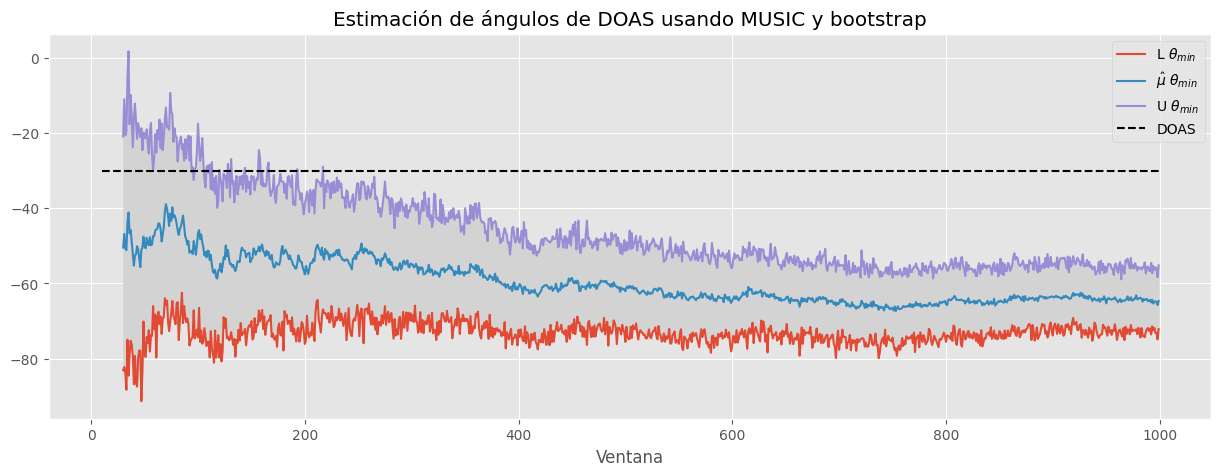

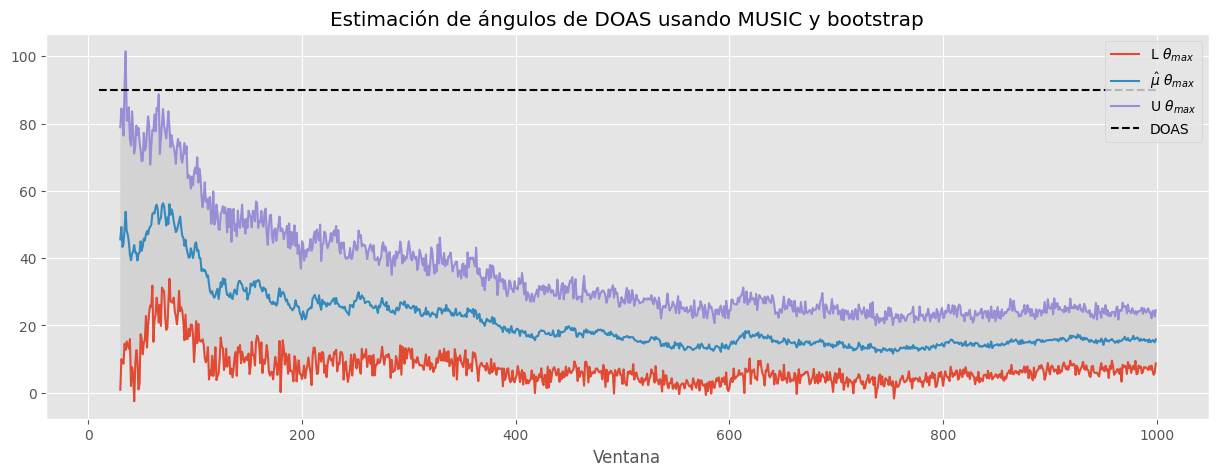

In [629]:
 plt.plot(num_angulos[20:],L[:,0],label='L $\\theta_{min}$')
plt.fill_between(x=num_angulos[20:],y1=L[:,0],y2=U[:,0],color='lightgrey')
plt.plot(num_angulos[20:],media[:,0],label='$\\hat{\\mu}$ $\\theta_{min}$')
plt.plot(num_angulos[20:],U[:,0],label='U $\\theta_{min}$')
plt.hlines(y=DOAS_AIRA[0],xmin=num_angulos[0],xmax=num_angulos[-1],colors='k',linestyles='dashed',label='DOAS')
plt.title('Estimación de ángulos de DOAS usando MUSIC y bootstrap');plt.xlabel('Ventana');plt.legend();plt.show()

plt.plot(num_angulos[20:],L[:,1],label='L $\\theta_{max}$')
plt.fill_between(x=num_angulos[20:],y1=L[:,1],y2=U[:,1],color='lightgrey')
plt.plot(num_angulos[20:],media[:,1],label='$\\hat{\\mu}$ $\\theta_{max}$')
plt.plot(num_angulos[20:],U[:,1],label='U $\\theta_{max}$')
plt.hlines(y=DOAS_AIRA[1],xmin=num_angulos[0],xmax=num_angulos[-1],colors='k',linestyles='dashed',label='DOAS')
plt.title('Estimación de ángulos de DOAS usando MUSIC y bootstrap');plt.xlabel('Ventana');plt.legend();plt.show()

# Vemos cuánto dura una iteración 

In [16]:
idx=this_idx_AIRA[0]
angles_AIRA=np.linspace(-90,90,50) # Los ángulos para buscar ortogonalidad
n_ruidoso=2
X=x_mics_AIRA
t1=time.time()
X=fft.fft(X,axis=1)
this_X=X[:,idx] # Esta es la que tiene que ser calculada usando ventanas anteriores. Cuando dividas en varias ventanas de Hann, se debería de ver una diferencia en la estimación
R=this_X.reshape(-1,1)*this_X.conj().T

D,Q=np.linalg.eig(R)
I=np.argsort(D.real)[::-1]
D=D[I]
Q=Q[:,I]

# Qs=Q[:,1:n_ruidoso]
Qn=Q[:,n_ruidoso:]
wi=this_ws_AIRA[0]
A_angles=A_AIRA(θs=angles_AIRA,freqs=[wi])

print(time.time()-t1)

0.002735137939453125


la lección aquí es reducir el número de ángulos de búsqueda y tal vez inferir el resto.

In [536]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from modAL.models import BayesianOptimizer
from modAL.acquisition import optimizer_EI, max_EI, max_UCB

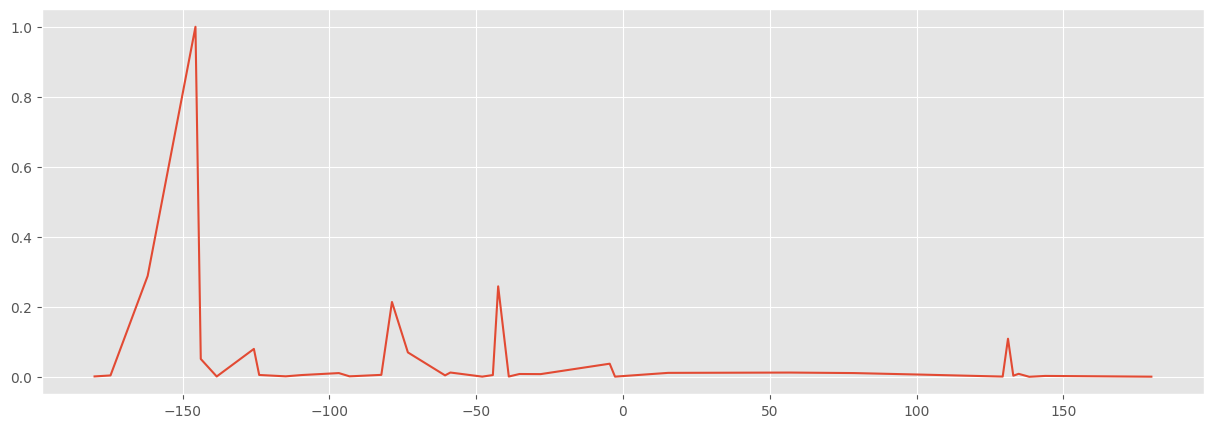

37

In [590]:

ms=DOAS_estimation(mic_path,angulos=np.linspace(-180,180,200))
ms.calcular_angulos_intensidades(ventana_inicial=v,nventanas=20,freq_low=100,freq_high=1000,umbral=30)

X_0=np.array(ms.angulos_maximos).reshape(-1)
y_0=np.array(ms.intensidad_maxima).reshape(-1)
# Por cada ángulo sacar la intensidad máxima
X=np.sort(pd.unique(X_0))
y=[]
for ang in X:
    y.append(y_0[X_0==ang].mean())
y=np.array(y)/np.array(y).max()

plt.plot(X,y);plt.show()
len(X)

In [591]:
# assembling initial training set
r_int=int(np.random.random()*len(X))
print(r_int)
X_initial, y_initial = X[r_int].reshape(1, -1), y[r_int].reshape(1, -1)

# defining the kernel for the Gaussian process
kernel = Matern(length_scale=.51)
regressor = GaussianProcessRegressor(kernel=kernel)

# initializing the optimizer
optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=X_initial, y_training=y_initial,
    query_strategy=max_UCB
)
# Bayesian optimization
for n_query in range(len(X)):
    query_idx, query_inst = optimizer.query(X.reshape(-1,1))
    print(query_idx)
    optimizer.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))

14
[13]
[15]
[12]
[10]
[0]
[1]
[2]
[3]
[4]
[16]
[9]
[3]
[18]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


/home/airchrysalis/.local/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/airchrysalis/.local/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[3]
[3]
[3]
[3]


/home/airchrysalis/.local/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [592]:
y_pred, y_std = optimizer.predict(X.reshape(-1,1) ,return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()
X_max, y_max = optimizer.get_max()

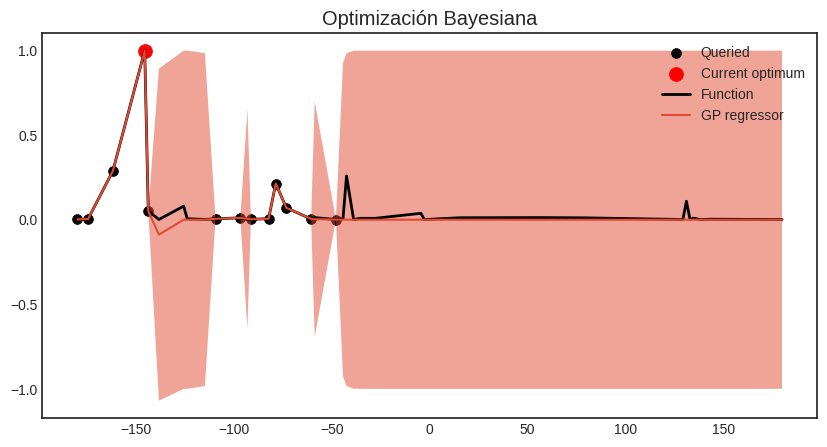

In [593]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.scatter(optimizer.X_training, optimizer.y_training, c='k', s=50, label='Queried')
    plt.scatter(X_max, y_max, s=100, c='r', label='Current optimum')
    plt.plot(X.ravel(), y, c='k', linewidth=2, label='Function')
    plt.plot(X.ravel(), y_pred, label='GP regressor')
    plt.fill_between(X.ravel(), y_pred - y_std, y_pred + y_std, alpha=0.5)
    plt.title('Optimización Bayesiana')
    plt.legend()
    plt.show()

In [573]:
X_max

array([-150.6122449])